This a brief tutorial to use HDP-GPC, a dynamic clustering library. 
As a summary of the objectives of this notebook:
1. Learn to load some public data and learn how compute the initial statistics.
2. Learn to define the model and check each one of the hyperparameters' configuration.
3. Learn to execute inference and how this can be tuned.
4. Learn how to plot the results and study the dynamic parameters.

We should first import the main packages to deal with the data:

In [61]:
import numpy as np
import torch
import os

Now we can load the data, to illustrate this example we are going to reduce the data to examples from 1800 to 1950.

In [62]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'mitbih')
data = np.load(os.path.join(data_path, '100.npy'))
labels = np.load(os.path.join(data_path, '100_labels.npy'))

print("Shape of the data: ")
print(data.shape)
data = data[1800:1950]
labels = labels[1800:1950]
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(2272, 90, 2)


The data dimensions correspond with [number of examples, number of observations, number of outputs]. Let's check how looks this data:

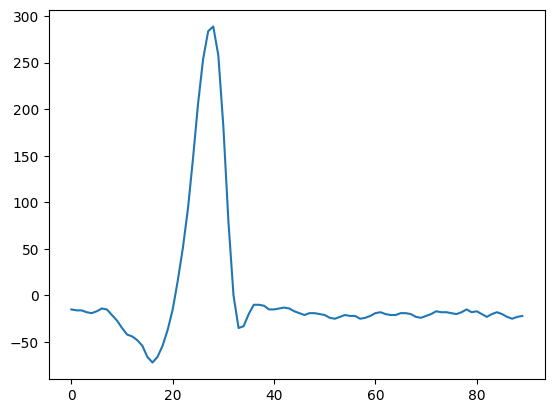

In [63]:
import matplotlib.pyplot as plt

plt.plot(data[0,:,0])
plt.show()

As we can see, it corresponds to a heartbeat. This is the kind of patterns we want to cluster over the record.
To compute the initial statistics we are going to use the observation variance and the 1-step rolled variance.
For that, we have a method in the get_data class, where we can choose the batch to compute this statistics.

In [64]:
from hdpgpc.get_data import compute_estimators_LDS

std, std_dif = compute_estimators_LDS(data, n_f=20)
print("Variance: ", str(std))
print("1-step variance: ", str(std_dif))


Variance:  146.33116788450926
1-step variance:  37.47354251854086


As we can see, the 1-step variance is lower than the variance, which indicates a prominent static behaviour.

Now we can define the HDP-GPC model. 

The hyperparameters can be directly estimated from the previously computed estimators. As a standard an initial M has to be chosen, as a default, it is chosen as M=2 as the model computes the needed number of clusters as it progresses in the inference.


In [65]:
M = 2
sigma = [std * 1.0] * M
bound_sigma_ = (std * 0.1, std * 0.2)
gamma = [std_dif * 1.0] * M
bound_gamma = (std_dif * 0.1, std_dif * 1.0)


We can also define the kernel parameters, in this case we are taking outputscale = 300.0 as is the mean amplitude found on a standard record of ECG. Also, we are choosing ini_legthscale = 3.0 as a standard value. Both can be tuned, but they do not have a critical impact on the inference because they are optimized in terms of Maximum-Likelihood.

In [66]:
outputscale_ = 300.0
ini_lengthscale = 3.0
bound_lengthscale = (1.0, 20.0)



Also, we have to define the time indexes where the observations had been taken, which is x_train. In this case it can be as simple as a range of the same length of the observations, but it can differ along the samples. On the other hand, we have to define x_basis, which is the time index basis where the LDS is going to be computed (it fix the dimension of the LDS) If desired, the x_basis can be reduced to be a set of inducing points. If this dimensional reduction is applied it should be reflected in the option parameter inducing_points=True. 

In [67]:
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
x_basis = np.atleast_2d(np.arange(l, L, 1, dtype=np.float64)).T
x_train = np.atleast_2d(np.arange(l, L, dtype=np.float64)).T
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False

Additionally, we can also define the warp GP hyperparameters and time indexes. 

In [68]:
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(l, L, 2, dtype=np.float64)).T

Finally, with these parameters we can define the HDP-GPC. 
There exist a lot of configuration parameters that can be combined in this model, to check the options and the relevance of these configuration options go to the Documentation (in progress).

In [69]:
import hdpgpc.GPI_HDP as hdpgp

sw_gp = hdpgp.GPI_HDP(x_basis, x_basis_warp=x_basis_warp, n_outputs=num_outputs,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma_, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, estimation_limit=50)

We can revise the priors that had been defined for our model.  The cluster list of GP-LDS is generated inside the model, indexes as gpmodels[n_output][n_cluster]. We can plot the zero-knowledge cluster.

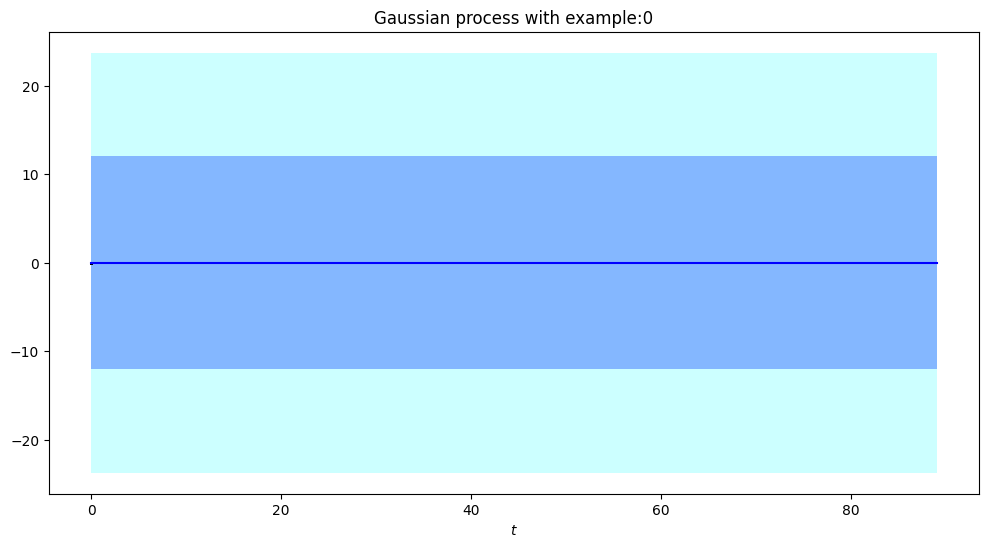

In [70]:
sw_gp.gpmodels[0][0].plot_last(0)

Once we have our model, now two inference options exist to cluster the data. 
1. In first place we have the online inference, where we can include one sample at a time and let the model cluster it. By now, the online inference only works with one output signal, but it is going to be extended soon.


In [71]:
data_ = data[:,:,[0]]
sw_gp.include_sample(x_train, data_[0], with_warp=warp)

Main model chosen: 1

 Fitting_GP: 

Iter 1/4000 - Loss: 114.253
Iter 501/4000 - Loss: 21.537
Iter 1001/4000 - Loss: 16.311
Iter 1501/4000 - Loss: 13.768
Iter 2001/4000 - Loss: 12.158
Iter 2501/4000 - Loss: 11.004
Iter 3001/4000 - Loss: 10.115
Iter 3501/4000 - Loss: 9.397


Parameter name: likelihood.noise_covar.raw_noise           value = [5.98803933]
Parameter name: mean_module.raw_constant                   value = -0.7456580569189888
Parameter name: covar_module.raw_outputscale               value = 93.64143959382594
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.63822687]]


Now the first example has been included in the model. 
We can check some parameters to be sure the sample has been added:

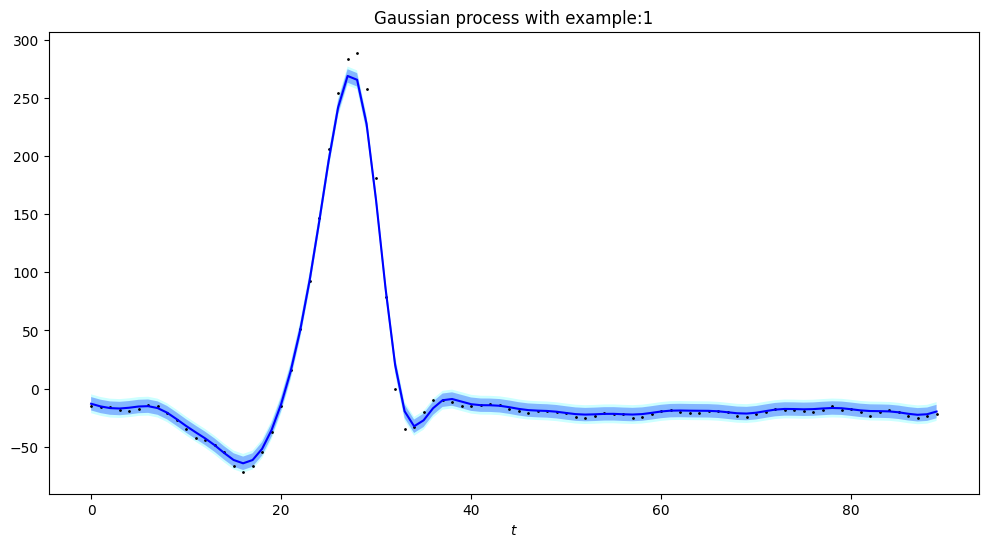

In [72]:
sw_gp.gpmodels[0][0].plot_last(0)

As we can see, the sample had been added successfully and the GP performed regression over it. Now we can include more samples, in this case, we are adding 100 to check how fast is the computation without warp component.

In [73]:
import time

for j, d in enumerate(data_[1:100]):
    start_time = time.time()
    print("Sample:", j, "/", str(data_.shape[0]-1), "label:", labels[j])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 0 / 149 label: N
Main model chosen: 1
Time --- 0.6402866840362549 seconds ---
Sample: 1 / 149 label: N
Main model chosen: 1
Time --- 0.06382918357849121 seconds ---
Sample: 2 / 149 label: N
Main model chosen: 1
Time --- 0.06682229042053223 seconds ---
Sample: 3 / 149 label: N
Main model chosen: 1
Time --- 0.0857701301574707 seconds ---
Sample: 4 / 149 label: N
Main model chosen: 1
Time --- 0.07380294799804688 seconds ---
Sample: 5 / 149 label: N
Main model chosen: 1
Time --- 0.06382894515991211 seconds ---
Sample: 6 / 149 label: N
Main model chosen: 1
Time --- 0.06682133674621582 seconds ---
Sample: 7 / 149 label: N
Main model chosen: 1
Time --- 0.06382918357849121 seconds ---
Sample: 8 / 149 label: N
Main model chosen: 1
Time --- 0.06682205200195312 seconds ---
Sample: 9 / 149 label: N
Main model chosen: 1
Time --- 0.06482648849487305 seconds ---
Sample: 10 / 149 label: N
Main model chosen: 1
Time --- 0.06682157516479492 seconds ---
Sample: 11 / 149 label: N
Main model chosen:

As every sample has been included in the first cluster we can check the state of it.

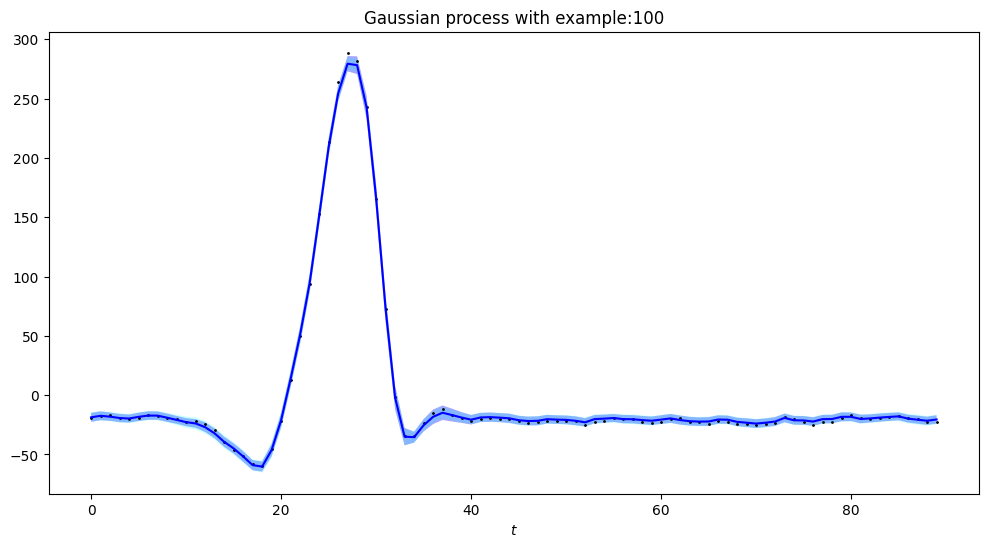

In [74]:
sw_gp.gpmodels[0][0].plot_last(0)

Even if we want to revise the beats included we can use the util_plot methods:

Model 1 : MainModel: N : [A-1,N-99]
Model 2  : []
Classification error:  1.0 / 100 -- 0.01


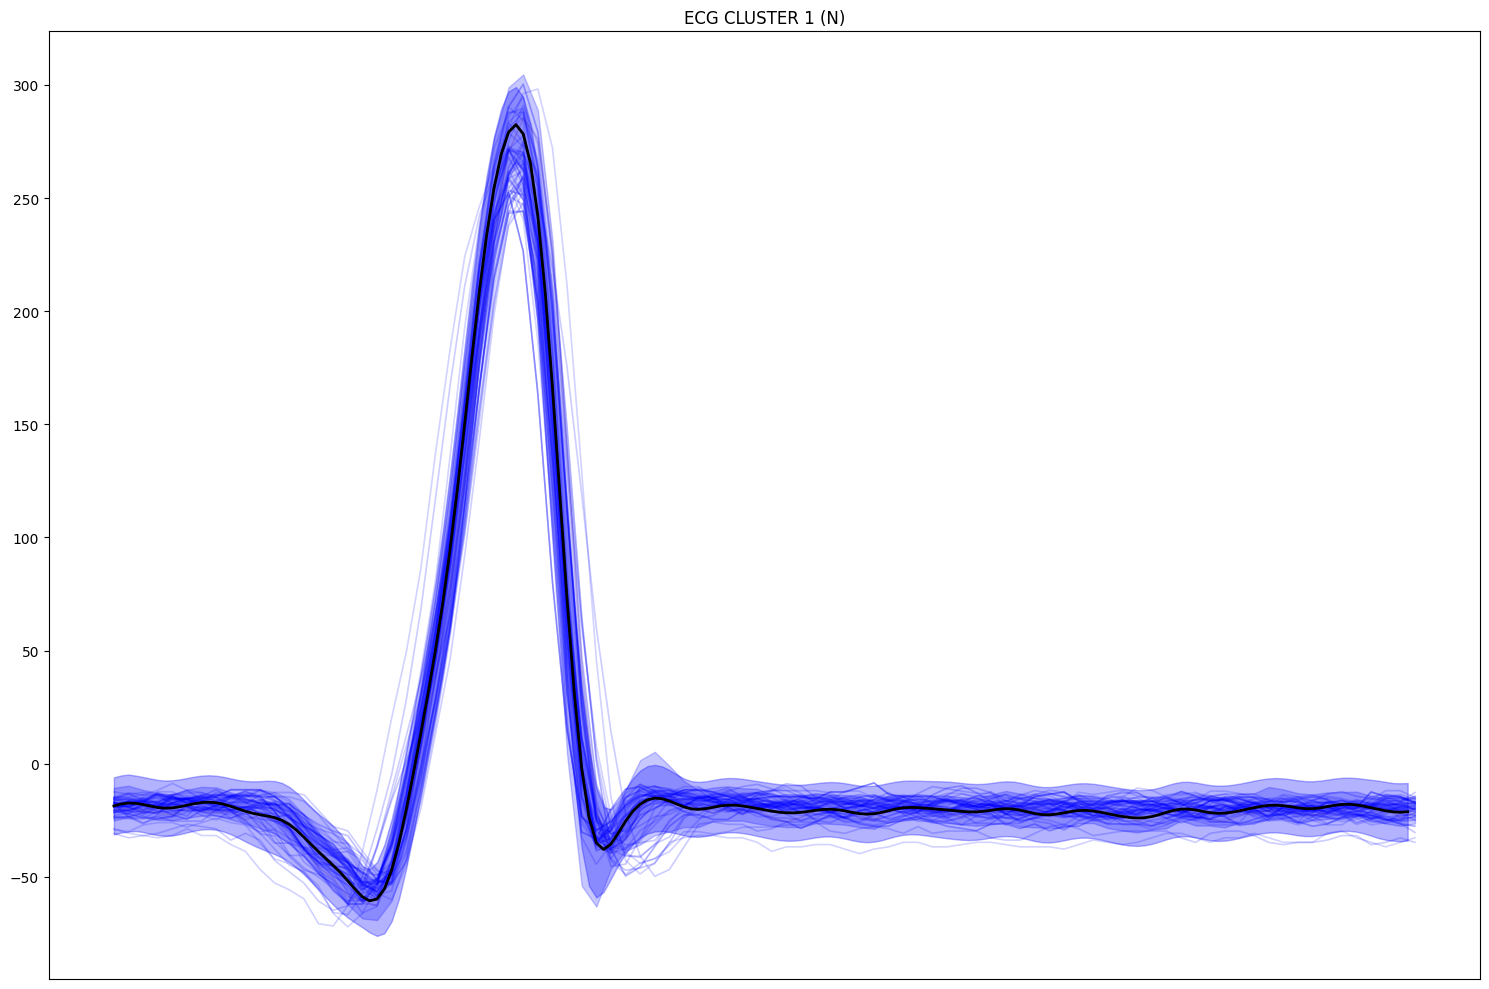

In [75]:
from hdpgpc.util_plots import print_results, plot_models_plotly

main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

If we try to include the examples from 1900 to 1950, knowing that a ventricular beat exist among them, we are going to check if the model generates a new group.

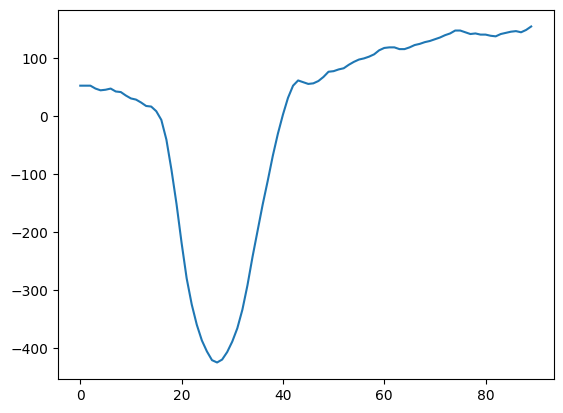

In [76]:
plt.plot(data_[106])


In [77]:

for j, d in enumerate(data_[100:]):
    start_time = time.time()
    print("Sample:", j+100, "/", str(data_.shape[0]-1), "label:", labels[j+100])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 0 / 149 label: N
Main model chosen: 1
Time --- 0.14461350440979004 seconds ---
Sample: 1 / 149 label: N
Main model chosen: 1
Time --- 0.1186833381652832 seconds ---
Sample: 2 / 149 label: N
Main model chosen: 1
Time --- 0.1356368064880371 seconds ---
Sample: 3 / 149 label: N
Main model chosen: 1
Time --- 0.12366914749145508 seconds ---
Sample: 4 / 149 label: N
Main model chosen: 1
Time --- 0.12067747116088867 seconds ---
Sample: 5 / 149 label: N
Main model chosen: 1
Time --- 0.12765908241271973 seconds ---
Sample: 6 / 149 label: N
Main model chosen: 1
Time --- 0.1376323699951172 seconds ---
Sample: 7 / 149 label: N
Main model chosen: 1
Time --- 0.1266613006591797 seconds ---
Sample: 8 / 149 label: N
Main model chosen: 1
Time --- 0.12466645240783691 seconds ---
Sample: 9 / 149 label: N
Main model chosen: 1
Time --- 0.11768555641174316 seconds ---
Sample: 10 / 149 label: N
Main model chosen: 1
Time --- 0.12267255783081055 seconds ---
Sample: 11 / 149 label: N
Main model chosen: 1

Model 1 : MainModel: N : [A-1,N-148,V-1]
Model 2  : []
Classification error:  2.0 / 150 -- 0.013333333333333334


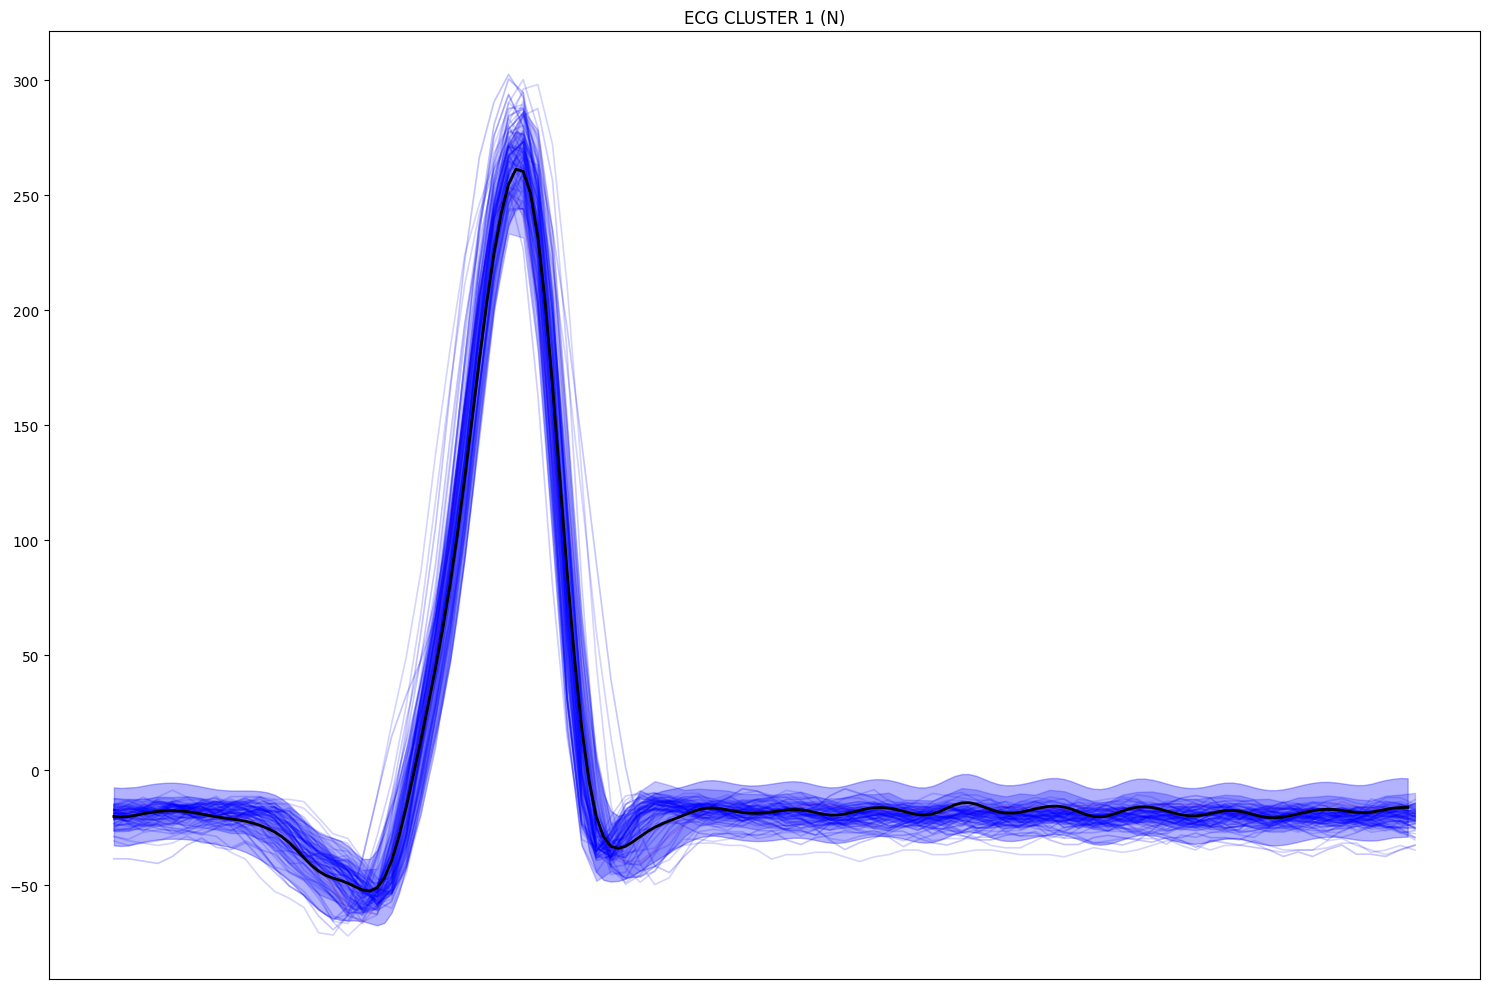

In [78]:
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)